# SessionM Code Challenge

Geoff Counihan, Nov 2nd, 3rd and 6th

Welcome to our problem set!

Each problem here has a number of points that we’ll use to score your submission. The total maximum
score you can obtain in this problem set is 100 points. We don’t expect our candidates to reach this score,
but encourage you to allocate your effort wisely to maximize how many points you get.

We are looking for solutions written in Python and encourage you to use open source packages and
libraries whenever possible. We value partial completion on any problem, even if with pseudocode, and
we also appreciate ideas on what else you would do if you had extra time. Please include any results and
CSV files you think are relevant. You can submit your solution anytime in the next few days. We will not
consider how much time it took you to prepare your submission, but hope it won’t take you more than 2h.

Please submit your solutions to avazquezreina@sessionm.com (DropBox link, zip file, etc). If you email
us a zip file, please send us a separate email to let us know you did so in case the original one gets
blocked by our spam/anti-virus filter. Certain questions are meant to be open ended, but feel free to
contact us with questions at any time. Good luck! :)

---
#### Additions since submitted


1. Consecutive day breakouts and drops, plus visualizations of the products involved for #2
2. Extend business days to df as index after forecasting
3. Create P and C matrixes based off linear trend predictions and the confidence interval spreads of the two products in #3
4. Use percent change as opposed to dollar change to determine single day anomolies in #4. Then using the median instead of the mean to find the largest percent increase days for all products or subsets of products.
5. Check out clusting to see if it could be useful in grouping products of similar trends

To do:
    
    Need to cut off the low at $0 for my predictions

[linear model](http://people.duke.edu/~rnau/411trend.htm)


---

In [1411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table

%matplotlib inline

In [588]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print('{} days and {} products'.format(*df.shape))

756 days and 428 products


1)​ ​Forecasting.​ ​50 points

Please help CoolBrand forecast how much profit they will have per product in each day during the next 30
days immediately following the dataset’s time window. Note that they need a forecast of multiple data
points (one per day) per product, not just a total single number per product for those 30 days. They will
value results even on a handful of their top products!

#### Thoughts

Plot a few of the products to see what their trends look like. These seem very much like random walk type data. Types of timeseries forcasts that could be used: 
    
    ARIMA (typically good 1-3 timesteps out, most likely not 30 out)
    Moving Avg, 
    Exp Moving Avg, 
    Seasonal Decomp (not seeing a seasonal trend here though),
    Trendline
    
Though ARIMA might work here, I don't have enough time to gridsearch all the products appropriately, so I expect I'll go with a simple trendline

In [589]:
df.iloc[-1].name

Timestamp('2017-10-20 00:00:00')

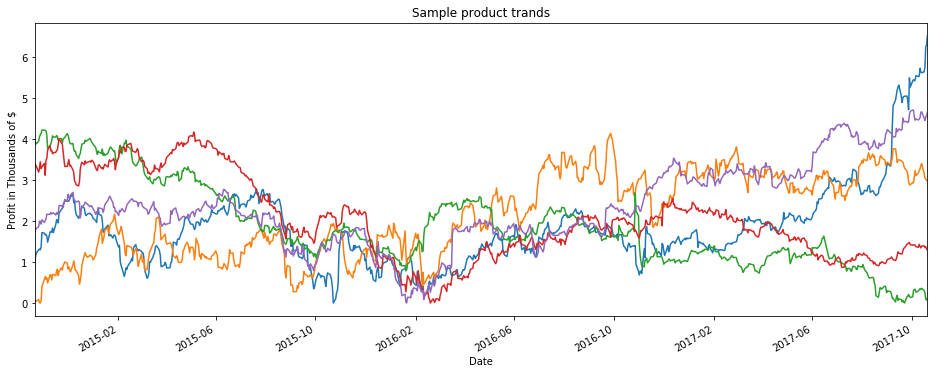

In [590]:
lrg = (16,6)
for i in range(0,200,40):
    df['{}'.format(i)].plot(figsize=lrg)
    plt.title('Sample product trends')
    plt.ylabel('Profit in Thousands of $')

#### Quick rolling averages

30 Day Moving Avg and 30 Day Exponential Moving Average, in retrospect these are better at giving an approximation of momentum and really good forecasts so I'll go with the simple trendline.

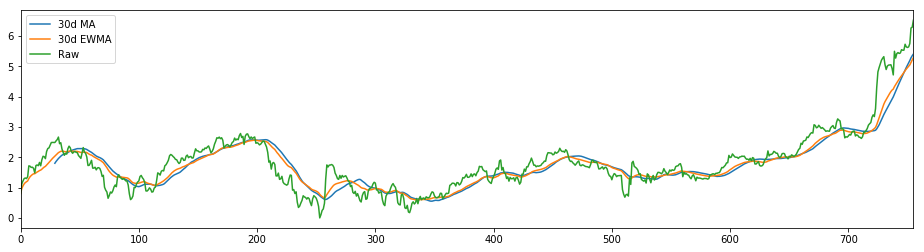

In [823]:
product = '0'
df[product].rolling(30).mean().plot(figsize=lrg,label='30d MA')
df[product].ewm(span=30).mean().plot(figsize=lrg,label='30d EWMA')
df[product].plot(figsize=(16,4),label='Raw')
plt.legend()

#### Create Trendline from last x days (set to 30) for each product

The trendline was misbehaving when I had the date as the index, so I reloaded the data intending to add it back in after doing the calculations.



In [805]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('Date',axis=1)

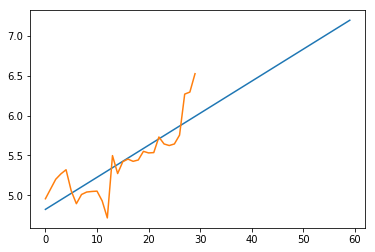

In [806]:
trend_from = 30

trend = sc.stats.linregress(range(df[-trend_from:].shape[0]), df[-trend_from:]['0'])
m = trend[0]
b = trend[1]
x = range(trend_from+30)
plt.plot(x,m * x + b)
plt.plot(range(df[-trend_from:].shape[0]), df[-trend_from:]['0'])

In [807]:
prods_forecast = pd.DataFrame()
ind_forecast = np.array([])
ind_idx = []
for i,x in enumerate(range(trend_from,trend_from+30)):
    last_idx = 755
    idx = last_idx + i + 1
    ind_idx.append(idx)
    ind_forecast = np.append(ind_forecast,m * x + b)

In [808]:
ind_forecast = pd.Series(ind_forecast)
ind_forecast.index = ind_idx
ind_forecast.name = '{}'.format(prod)

In [809]:
prods_forecast = pd.concat([prods_forecast,ind_forecast],axis=1)
prods_forecast.head()

,427
756,6.029005
757,6.069110
758,6.109214
759,6.149319
760,6.189424


Create and add all predictions to the original dataframe. Now calculate top performers based on the forcast.

In [810]:
prods_forecast = pd.DataFrame()

for prod in df.columns:
    trend_from = 30

    trend = sc.stats.linregress(range(df[-trend_from:].shape[0]), df[-trend_from:][prod])
    m = trend[0]
    b = trend[1]
    x = range(trend_from+30)
    
    ind_forecast = np.array([])
    ind_idx = []
    
    for i,x in enumerate(range(trend_from,trend_from+30)):
        last_idx = 755
        idx = last_idx + i + 1
        ind_idx.append(idx)
        ind_forecast = np.append(ind_forecast,m * x + b)
    
    ind_forecast = pd.Series(ind_forecast)
    ind_forecast.index = ind_idx
    ind_forecast.name = '{}'.format(prod)
    
    prods_forecast = pd.concat([prods_forecast,ind_forecast],axis=1)

In [819]:
def add_date_index(df_forecast):
    # fills for values up to the beginning of next year
    df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
    dates = pd.to_datetime(df['Date'])
    start = datetime(2017, 10, 23)
    end = datetime(2018, 1, 1)
    rng = pd.Series(pd.bdate_range(start, end))
    df_forecast['Date'] = dates.append(rng).reset_index(drop=True)
    df_forecast = df_forecast.set_index('Date')
    return df_forecast

In [822]:
df_forecast = pd.concat([df,prods_forecast],axis=0)
df_forecast = add_date_index(df_forecast)
df_forecast.head()

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,427
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-22,0.801904,0.029146,0.095752,0.003619,0.241878,2.535904,4.240986,0.038281,0.310240,0.543723,...,0.244417,1.568204,0.180691,0.547740,0.621678,0.371033,0.366755,0.999874,0.957433,0.000000
2014-10-23,1.117338,0.000000,0.089933,0.000000,0.222267,2.599584,4.358325,0.043066,0.306067,0.574200,...,0.209500,1.567310,0.180691,0.452783,0.631193,0.437978,0.334989,1.460067,1.003781,0.016562
2014-10-24,1.216875,0.041942,0.087552,0.027341,0.226625,2.532743,4.282893,0.032433,0.340847,0.565492,...,0.137339,1.300724,0.197117,0.507209,0.656568,0.443652,0.359054,1.376395,0.982594,0.039147
2014-10-27,1.296785,0.066823,0.116384,0.037795,0.222267,2.640683,4.249367,0.061675,0.378410,0.565492,...,0.202517,1.310564,0.193010,0.531528,0.723176,0.433440,0.343652,1.418231,0.986566,0.066248
2014-10-28,1.317814,0.071089,0.239645,0.084838,0.235341,2.717911,4.148790,0.000000,0.470229,0.614256,...,0.307267,1.354398,0.203278,0.525738,0.910314,0.574138,0.397558,1.676566,1.083237,0.102384


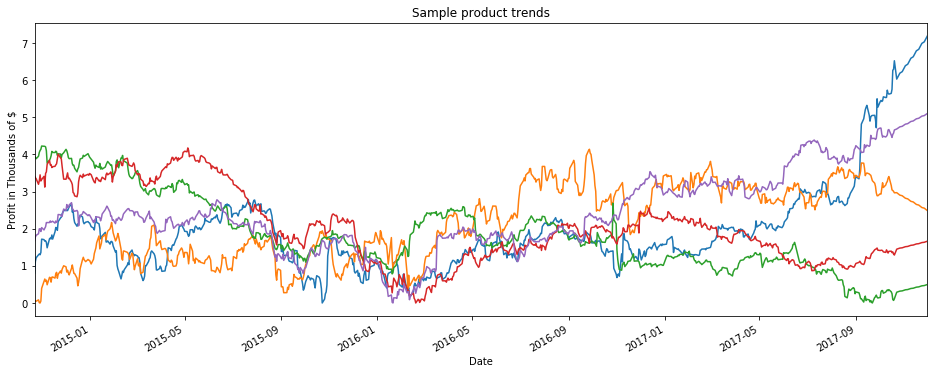

In [818]:
lrg = (16,6)
for i in range(0,200,40):
    df_forecast['{}'.format(i)].plot(figsize=lrg)
    plt.title('Sample product trends')
    plt.ylabel('Profit in Thousands of $')

These are my top 20 most profitable products and their forecasted profits in dollars based on a 30 day linear trendline.

In [820]:
np.round(df[-30:].sum().sort_values(ascending=False).iloc[:20]*1000,2)

313    178067.28
0      162221.54
99     150841.66
272    149345.24
335    148051.84
31     144597.70
218    144290.20
391    139836.74
88     139812.40
127    139252.27
255    138853.06
179    138674.64
271    138497.50
404    138432.94
415    137988.77
343    137023.82
373    136640.47
93     136486.41
325    136272.38
148    135636.54
dtype: float64

2)​ ​Trends​ ​and​ ​transitions.​ ​90 points

CoolBrand competes with other companies in the market and sometimes it notices multi-day drops and
increases in profitability. They speculate they are the result of promotions from other companies and/or
changes in consumer preference. They have a hard time separating these trends from “natural” random
variation. Assuming that CoolBrand didn’t change anything on their end (pricing, advertising, promotions,
etc) during the dataset’s time window, can you help them identify significant transitions in the data?

#### Thoughts

Find when the trends deviate outside of a tresholded moving std. 68, 95, 99.7 rule. 95% of the data lies within 2 std so std = 2, this will trigger on the rarest 2.5% of highs and 2.5% of lows within the 30 day moving window

The way its phrased makes me think CoolBrand could be looking for consecutive day ups or downs as well

In [2074]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [2075]:
def extremes(df,prod,thresh=2,window=30):
    df_outliers = pd.DataFrame()
    df_outliers['{}_upper'.format(prod)] = (df[prod] > (df[prod].rolling(window).mean() + thresh*df[prod].rolling(window).std())).astype(int)
    df_outliers['{}_lower'.format(prod)] = (df[prod] < (df[prod].rolling(window).mean() - thresh*df[prod].rolling(window).std())).astype(int)
    return df_outliers

#### Spotcheck to confirm

Upper and lower are triggering when product is going above/below mean - (2 x std)

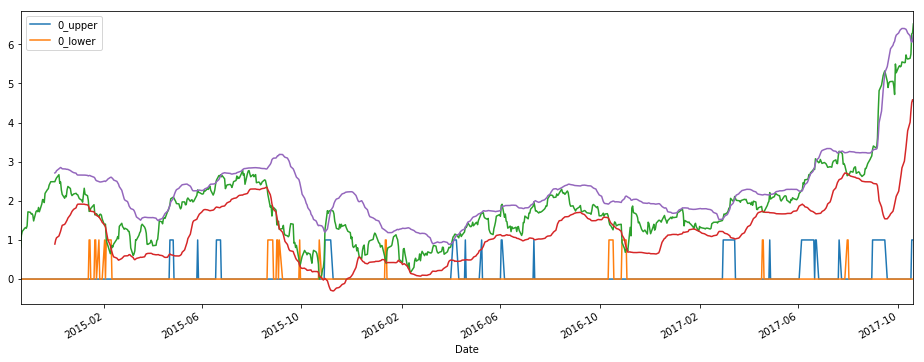

In [2076]:
lrg = (16,6)
prod = '0'
df_outliers = extremes(df,prod)
df_outliers.plot(figsize=lrg)
df[prod].plot(figsize=lrg)
(df[prod].rolling(30).mean() - 2*df[prod].rolling(30).std()).plot(figsize=lrg)
(df[prod].rolling(30).mean() + 2*df[prod].rolling(30).std()).plot(figsize=lrg)

In [2077]:
df_outliers = pd.DataFrame()
for col in df.columns:
    df_outliers = pd.concat([df_outliers,extremes(df,col,thresh=2)],axis=1)

In [2078]:
df_upper = df_outliers[[col for col in df_outliers if 'upper' in col]]
df_lower = df_outliers[[col for col in df_outliers if 'lower' in col]]

Though not terribly pretty, there are noticable light lines in the heatmaps which indicate that multiple products are jumping out of their upper and lower 2std range on roughly the same dates. Especially true in the products dropping below the lower bound

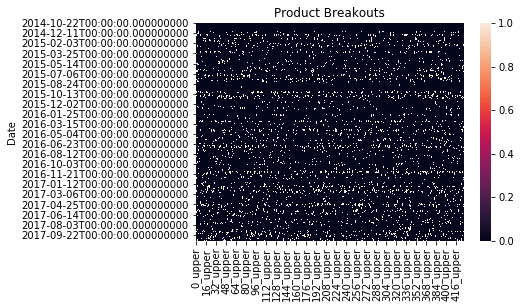

In [2079]:
sns.heatmap(df_upper)
plt.title('Product Breakouts')

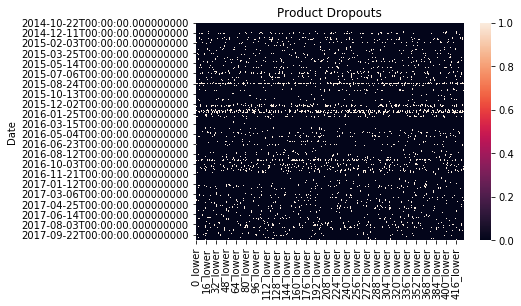

In [2080]:
sns.heatmap(df_lower)
plt.title('Product Dropouts')

Looking more closely, its actually a good amount of the products. If we divide the count of products breaching the upper 2std limit per day by the number of products we get the % products that are breakingout.

In [2081]:
perc_products_breakout = .30
df_upper.index[((df_upper.sum(axis=1)/df_upper.shape[1])>perc_products_breakout)].tolist()

[Timestamp('2016-11-10 00:00:00')]

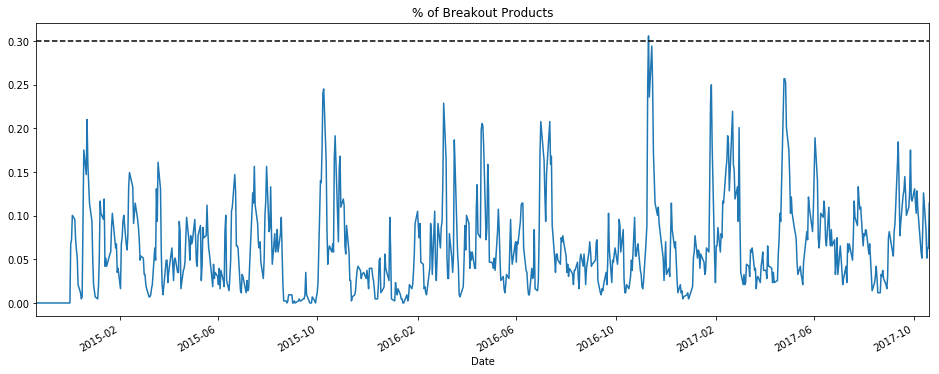

In [2082]:
(df_upper.sum(axis=1)/df_upper.shape[1]).plot(figsize=lrg)
plt.axhline(y=perc_products_breakout, color='black', linestyle='--')
plt.title('% of Breakout Products')

We can do the same for the products dropping out. This seems like its a little more alarming, since there are upwards of 50% of all products dropping out at similar times. More investigation would be needed to figure out what is going on.

In [2083]:
perc_products_dropout = .30
df_lower.index[((df_lower.sum(axis=1)/df_lower.shape[1])>perc_products_dropout)].tolist()

[Timestamp('2015-08-24 00:00:00'),
 Timestamp('2015-08-25 00:00:00'),
 Timestamp('2015-08-26 00:00:00'),
 Timestamp('2016-01-07 00:00:00'),
 Timestamp('2016-01-08 00:00:00'),
 Timestamp('2016-01-11 00:00:00'),
 Timestamp('2016-01-12 00:00:00'),
 Timestamp('2016-01-14 00:00:00'),
 Timestamp('2016-01-15 00:00:00'),
 Timestamp('2016-01-20 00:00:00'),
 Timestamp('2016-06-27 00:00:00'),
 Timestamp('2016-06-28 00:00:00'),
 Timestamp('2016-09-14 00:00:00')]

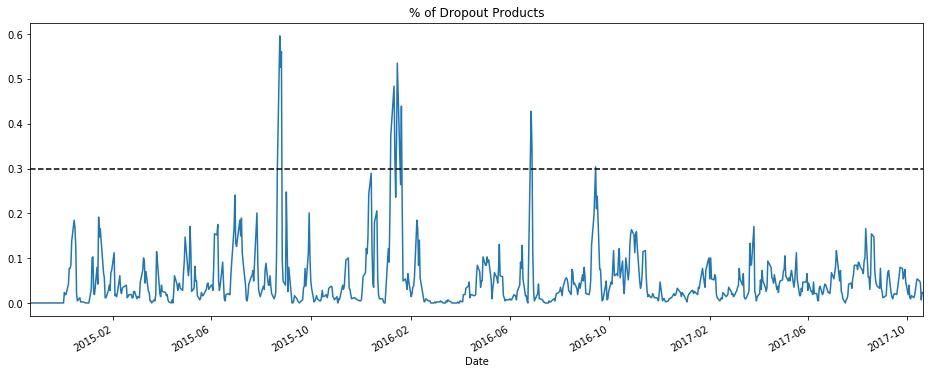

In [2084]:
(df_lower.sum(axis=1)/df_lower.shape[1]).plot(figsize=lrg)
plt.axhline(y=perc_products_dropout, color='black', linestyle='--')
plt.title('% of Dropout Products')

#### Additional Work

If you look at it in terms of consecutive days, perhaps there will be a different trend. Lets do that, and make it flexible to create multiple consecutive days. This filters out which drops are multiday long

In [2085]:
def consecutive(df_outliers,prod,durs=[1,2,3]):
    df_consec = pd.DataFrame()
    for dur in durs:
        df_consec['{}_consec_{}_days'.format(prod,dur)] = (df_outliers[prod].rolling(dur).sum() == dur).astype(int)
    return df_consec

In [2086]:
#prods = ['0_upper','20_upper']
durs = [1,2,3,4,5]

df_consec = pd.DataFrame()
for col in df_outliers.columns:
    df_consec = pd.concat([df_consec,consecutive(df_outliers,col,durs)],axis=1)

In [2087]:
df_upper_consec = df_consec[[col for col in df_consec if 'upper' in col]]
df_lower_consec = df_consec[[col for col in df_consec if 'lower' in col]]

Sort columns so each of the consecutive sections will be together. Thereforet he below chart is techinclly broken into 5 different sections. My expectation was there would be far less highlights as the consecutive days progressed longer - which due to an error wasn't happening the first time I graphed it.

However, below is now the expected result where consecutive 5day breakouts are much rarer than 1day breakouts.

In [2088]:
cols = df_upper_consec.columns
cols = sorted(cols, key=lambda col: int(col[-6]))
df_upper_consec = df_upper_consec[cols]

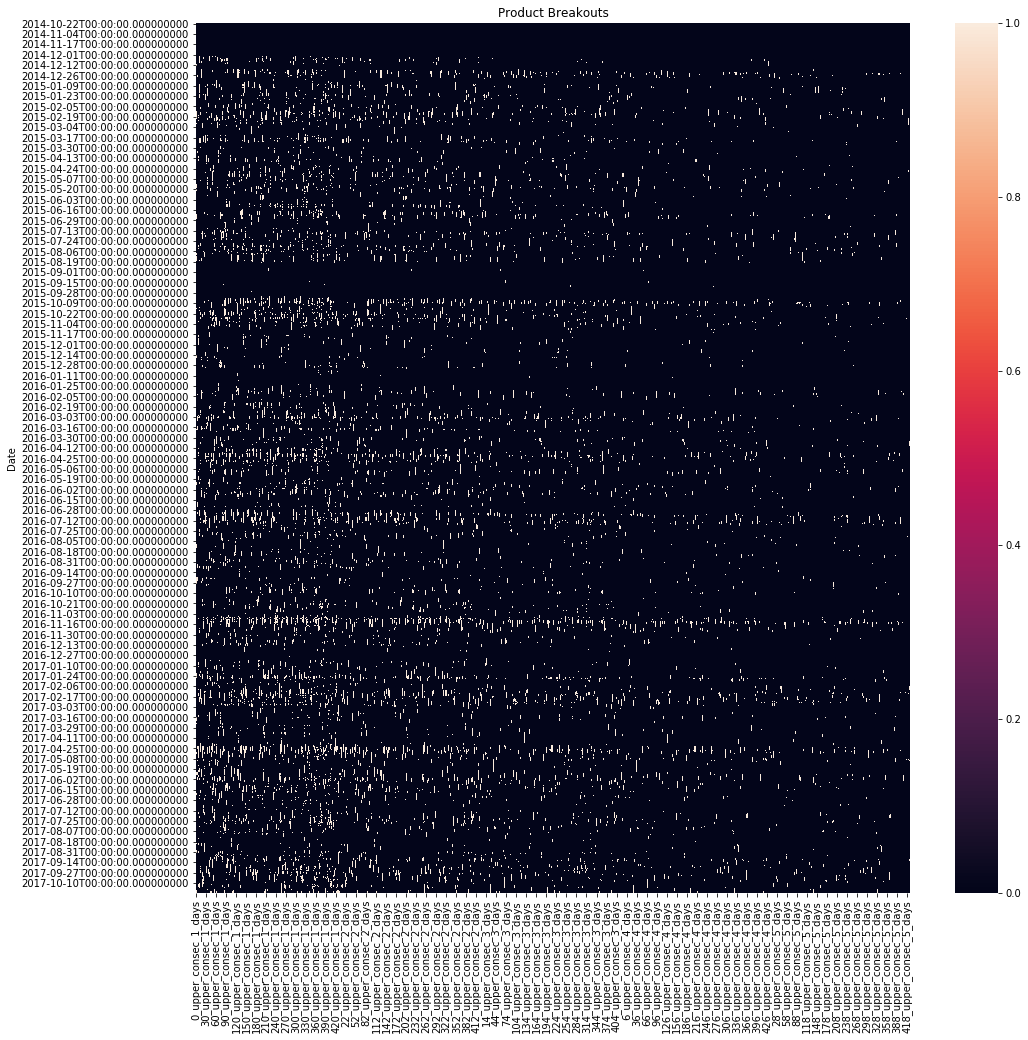

In [2089]:
fig, ax = plt.subplots(figsize=(16,16)) 
sns.heatmap(df_upper_consec, ax=ax)
plt.title('Product Breakouts')

Quick sanity check, originally my sorting of columns was only renaming instead of rearanging which lead to more 5 day breakouts than 3day breakouts.. thats not possible!

In [2090]:
day = 1
for day in [1,2,3,4,5]:
    count = df_upper_consec[[col for col in df_upper_consec.columns if '{}_days'.format(day) in col]].sum().sum()
    print('{} days and {} many breakouts across all products'.format(day,count))

1 days and 20757 many breakouts across all products
2 days and 12991 many breakouts across all products
3 days and 8201 many breakouts across all products
4 days and 5116 many breakouts across all products
5 days and 3038 many breakouts across all products


In [2091]:
cols = df_lower_consec.columns
cols = sorted(cols, key=lambda col: int(col[-6]))
df_lower_consec = df_lower_consec[cols]

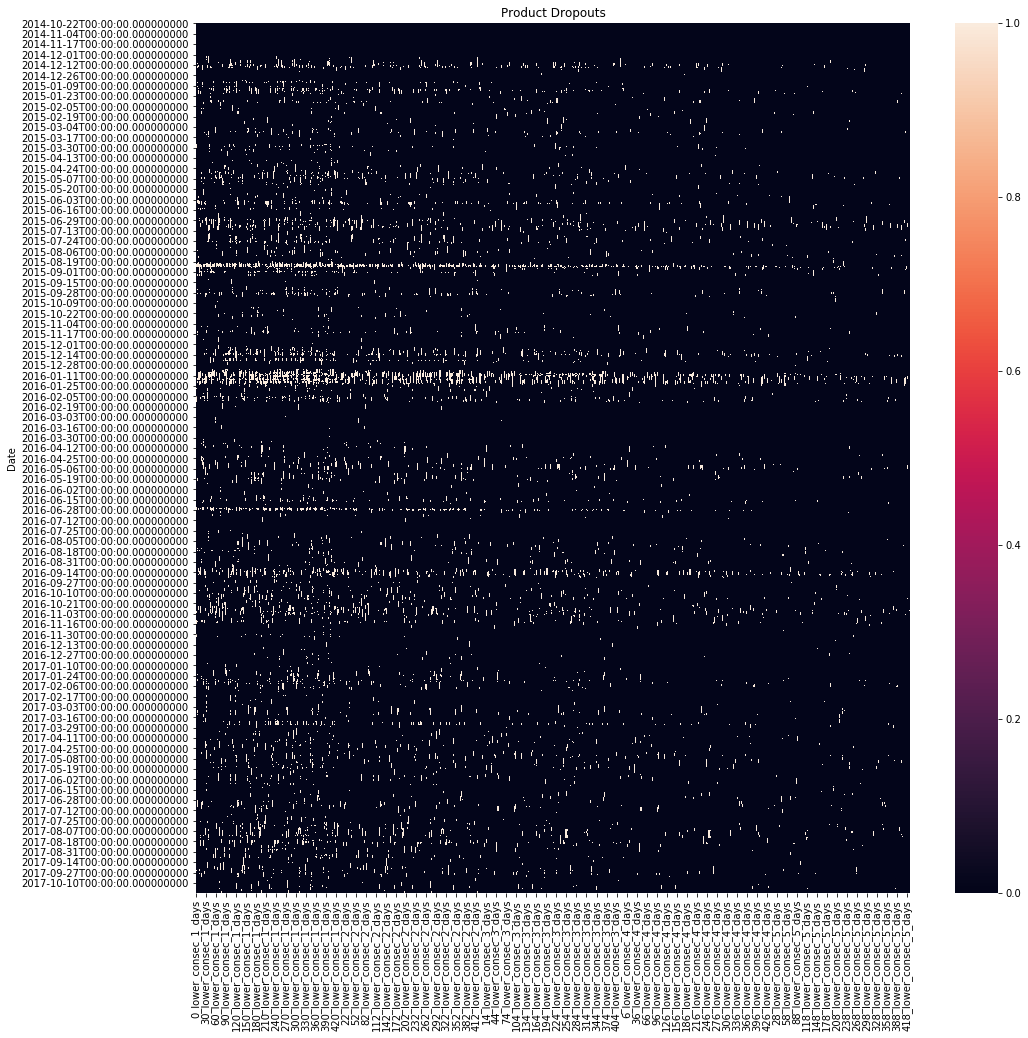

In [2092]:
fig, ax = plt.subplots(figsize=(16,16)) 
sns.heatmap(df_lower_consec, ax=ax)
plt.title('Product Dropouts')

Here are the top dates which ended a 5 day run of breakout or dropout days. We can take a look at the products that compose each of the dates as well - CoolBrand would want to know which product skus are being affected

In [2093]:
def top_dates(df_upper_consec,dur=5,position=0):
    top_breakout_df = df_upper_consec[[col for col in df_upper_consec if '{}_days'.format(dur) in col]]
    top_breakout_date = top_breakout_df.sum(axis=1).sort_values(ascending=False).index[position]

    top_breakout_cols = list(top_breakout_df[top_breakout_df == 1].loc[top_breakout_date].dropna().index)

    top_breakout_prods = []
    for col in top_breakout_cols:
        top_breakout_prods.append(col.split('_')[0])
    return top_breakout_date,top_breakout_prods

In [2096]:
dur = 2
df_upper_consec[[col for col in df_upper_consec if '{}_days'.format(dur) in col]].sum(axis=1).sort_values(ascending=False)[:10]

Date
2016-11-15    98
2016-11-10    98
2016-11-14    97
2016-11-11    96
2015-10-09    91
2017-04-27    86
2017-01-26    85
2017-04-26    85
2017-04-25    81
2017-04-28    72
dtype: int64

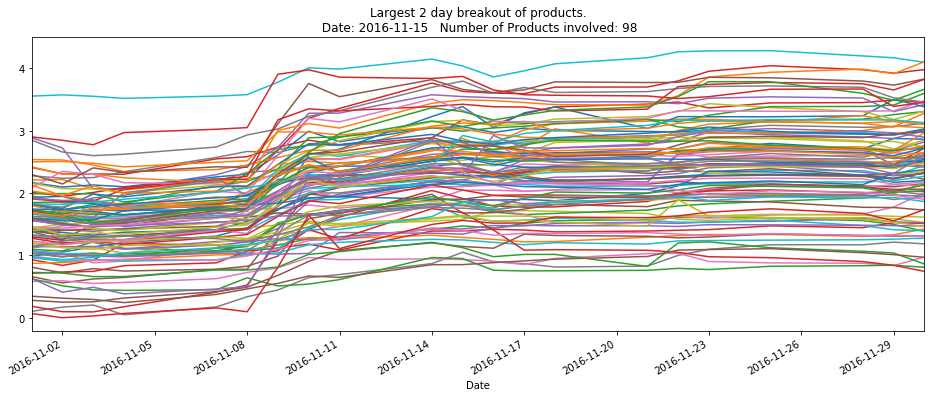

In [2097]:
top_dropout_date, top_dropout_prods = top_dates(df_upper_consec,dur)
top_dropout_day = '{}-{}-{}'.format(top_dropout_date.year,top_dropout_date.month,top_dropout_date.day)
top_dropout_viz = '{}-{}'.format(top_dropout_date.year,top_dropout_date.month)
df[top_dropout_prods][top_dropout_viz].plot(figsize=lrg,legend=False)
plt.title('Largest {} day breakout of products.\n Date: {}   Number of Products involved: {}'.format(dur,top_dropout_day,len(top_dropout_prods)))


In [2106]:
dur = 3
df_lower_consec[[col for col in df_lower_consec if '{}_days'.format(dur) in col]].sum(axis=1).sort_values(ascending=False)[:10]

Date
2015-08-26    189
2016-01-11    138
2015-08-25    121
2016-01-12    102
2016-01-20     93
2016-01-19     91
2016-01-08     82
2016-01-13     81
2016-01-15     79
2016-01-14     72
dtype: int64

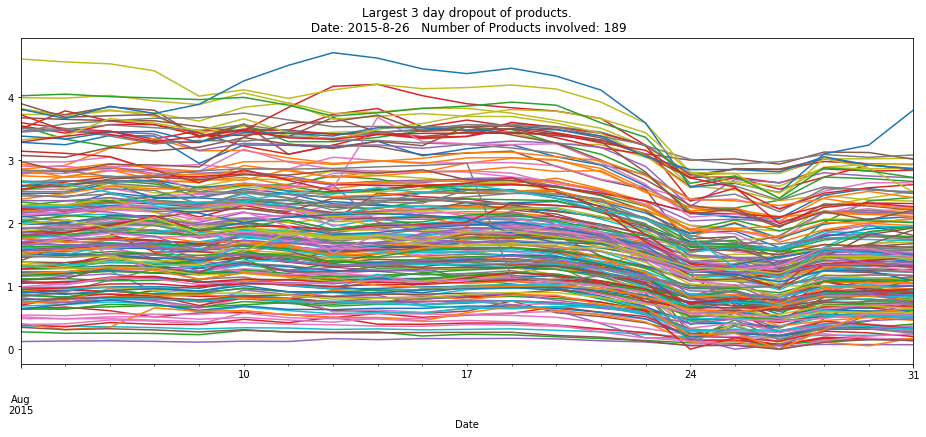

In [2107]:
top_dropout_date, top_dropout_prods = top_dates(df_lower_consec,dur)
top_dropout_day = '{}-{}-{}'.format(top_dropout_date.year,top_dropout_date.month,top_dropout_date.day)
top_dropout_viz = '{}-{}'.format(top_dropout_date.year,top_dropout_date.month)
df[top_dropout_prods][top_dropout_viz].plot(figsize=lrg,legend=False)
plt.title('Largest {} day dropout of products.\n Date: {}   Number of Products involved: {}'.format(dur,top_dropout_day,len(top_dropout_prods)))

3)​ ​Comparisons.​ 80 points

CoolBrand executives are interested in comparing the total profitability of their products during the rest of 2017. They are looking to get two matrices. The first one P would contain elements P(i,j) with your
estimate of the difference in profit between product i and j (e.g. in thousands of $ or %) during the time left
in the year. The second one C would contain elements C(i,j) with your confidence in the corresponding
P(i,j) estimation. They would like you to compute C(i,j) and P(i,j) on at least a handful of their top products.

#### Thoughts

I'm having a hard time intuatively thinking what these are useful for, which I think is why I'm having a difficulty seeing the value. I've produced the P matrix, but I can't discern its utility.

P - can create easily based on modifying the df from above.

C - I haven't ever created confidence intervals from scratch based on a linear trendline formula and accompanying values: stderror, pvalue, and rvalue. Using statsmodels may be easier to auto calculate it but I'd like to learn how it works and will continue to work on this over the weekend.

#### Additional Thoughts

After talking with a data scientist friend about the use of this, I have a much clearer idea of why this would be helpful. Basically, getting not only the expected profit but the confidence of the prediction gives you the ability to judge not the likely range of estimated profit. Though I haven't created a function for it, you could theoretically create a way to extract the highest profitable products with the lowest confidence spreads or just brute force it and set spread below a threshold and find the max profit.

I thought CoolBrand might be interested in the predictions I'm most confident in based on the highest R2 or lowest stderr values which I briefly looked at but didn't do more analysis on. I figure the lowest stderr ultimately produce the smallest confidence intervals so the idea propigates to using the C matrix anyways.

In [2050]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('Date',axis=1)

In [2051]:
prods_forecast = pd.DataFrame()
prods_forecast_params = {}

for prod in df.columns:
    trend_dur = 50
    forecast_dur = 50

    trend = sc.stats.linregress(range(df[-trend_dur:].shape[0]), df[-trend_dur:][prod])
    m = trend[0]
    b = trend[1]
    x = range(trend_dur+forecast_dur)
    
    rval = trend[2]
    pval = trend[3]
    stderr = trend[4]
    prods_forecast_params['{}'.format(prod)] = [m,b,rval,pval,stderr]
    
    
    ind_forecast = np.array([])
    ind_idx = []
    
    for i,x in enumerate(range(trend_dur,trend_dur+forecast_dur)):
        last_idx = 755
        idx = last_idx + i + 1
        ind_idx.append(idx)
        ind_forecast = np.append(ind_forecast,m * x + b)
    
    ind_forecast = pd.Series(ind_forecast)
    ind_forecast.index = ind_idx
    ind_forecast.name = '{}'.format(prod)
    
    prods_forecast = pd.concat([prods_forecast,ind_forecast],axis=1)

In [2052]:
df_forecast_yearend = pd.concat([df,prods_forecast],axis=0)
df_forecast_yearend = add_date_index(df_forecast_yearend)

In [2053]:
top_x = 5
forecast_dur = 50
top_yearend_prods = list(df_forecast_yearend[-forecast_dur:].sum().sort_values(ascending=False).iloc[:top_x].index)
top_yearend_prods

['0', '313', '179', '335', '310']

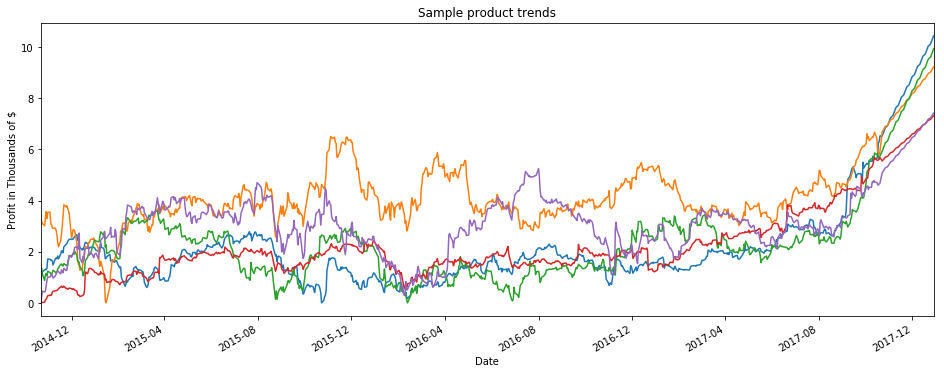

In [2054]:
lrg = (16,6)
for i in top_yearend_prods:
    df_forecast_yearend['{}'.format(i)].plot(figsize=lrg)
    plt.title('Sample product trends')
    plt.ylabel('Profit in Thousands of $')

I can use the R value to gauge confidence in the predictions to find the strongest forecasts

In [2055]:
df_forecast_yearend_params = pd.DataFrame(prods_forecast_params)
df_forecast_yearend_params.index = ['slope','intercept','rvalue','pvalue','stderr']

In [2056]:
top_x = 20
# this is actually the lines with the highest slope it seems
highest_confidence_prods = (df_forecast_yearend_params.loc['rvalue']**2).sort_values(ascending=False).index[:top_x]
lowest_stderr_prods = (df_forecast_yearend_params.loc['stderr']).sort_values().index[:top_x]
highest_pval_prods = (df_forecast_yearend_params.loc['pvalue']).sort_values(ascending=False).index[:top_x]
lowest_pval_prods = (df_forecast_yearend_params.loc['pvalue']).sort_values().index[:top_x]

In [1412]:
df_forecast_yearend_params[df_forecast_yearend_params['stderr'] < .001].sort_values(by='slope',ascending=False).head()

,slope,intercept,rvalue,pvalue,stderr
266,0.035686,2.260093,0.982648,8.804867e-37,0.000972
194,0.028514,3.372217,0.982666,8.582733e-37,0.000776
251,0.027651,2.970876,0.979741,3.506666e-35,0.000816
229,0.026325,2.706065,0.968464,1.266889e-30,0.000978
272,0.025715,4.099471,0.980920,8.426960e-36,0.000736


In [2071]:
#df_forecast_yearend[lowest_stderr_prods].plot()

In [2072]:
#df_forecast_yearend[highest_confidence_prods].plot()

#### Additional Work

I used statsmodels over the weekend, which provides the upper and lower confidence intervals for the prediction range. I've produced the spread of each of these for each product, and then created a matrix C which adds product1's conidence spread with product2 confidence spread. 

From there I can divide it by 2 to get the confidence above and below the prediction and determine the range in which the expected profit is probable 95% of the time. 

In [2059]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('Date',axis=1)

In [2108]:
prods_forecast = pd.DataFrame()
prods_confid = pd.DataFrame()
prods_forecast_params = {}

for prod in df.columns:
    last_idx = 755
    trend_dur = 50
    forecast_dur = 50
    
    x = np.linspace(0,df[-trend_dur:].shape[0]-1,trend_dur)
    X = sm.add_constant(x)
    y = df[-trend_dur:][prod]
    re = sm.OLS(y, X).fit()

    new_x = np.linspace(trend_dur,trend_dur+forecast_dur-1,trend_dur)
    new_x = sm.add_constant(new_x) 
    y_predict = re.predict(new_x)
    prstd, iv_l, iv_u = wls_prediction_std(re,exog=new_x)
    iv_spread = iv_u-iv_l

    ind_idx = [i+1+last_idx for i in range(forecast_dur)]
    
    ind_forecast = pd.Series(y_predict)
    ind_forecast.index = ind_idx
    ind_forecast.name = '{}'.format(prod)
    
    ind_iv_u = pd.Series(iv_u)
    ind_iv_u.index = ind_idx
    ind_iv_u.name = '{}_iv_u'.format(prod)
    
    ind_iv_l = pd.Series(iv_l)
    ind_iv_l.index = ind_idx
    ind_iv_l.name = '{}_iv_l'.format(prod)
    
    ind_confid = pd.Series(iv_spread)
    ind_confid.index = ind_idx
    ind_confid.name = '{}'.format(prod)
    
    
#    prods_forecast = pd.concat([prods_forecast,ind_forecast],axis=1)
    prods_forecast = pd.concat([prods_forecast,ind_forecast,ind_iv_u,ind_iv_l],axis=1)
    prods_confid = pd.concat([prods_confid,ind_confid],axis=1)

df_forecast_yearend = pd.concat([df,prods_forecast],axis=0)
df_forecast_yearend = add_date_index(df_forecast_yearend)
prods_confid = add_date_index(prods_confid)

In [2062]:
only_prods = [col for col in prods_forecast.columns if '_' not in col]

A = prods_forecast[only_prods].sum().values
B = prods_forecast[only_prods].sum().values
P = pd.DataFrame(A[:,np.newaxis] - B).abs()

D = prods_confid.sum().values
E = prods_confid.sum().values
C = pd.DataFrame(D[:,np.newaxis] + E)#.abs()

#### Example

Display 2 products the corresponding error

P1 Profit: 396.57
P2 Profit: 300.94
P1 over P2 profit: 95.63
Error +/- 56.94


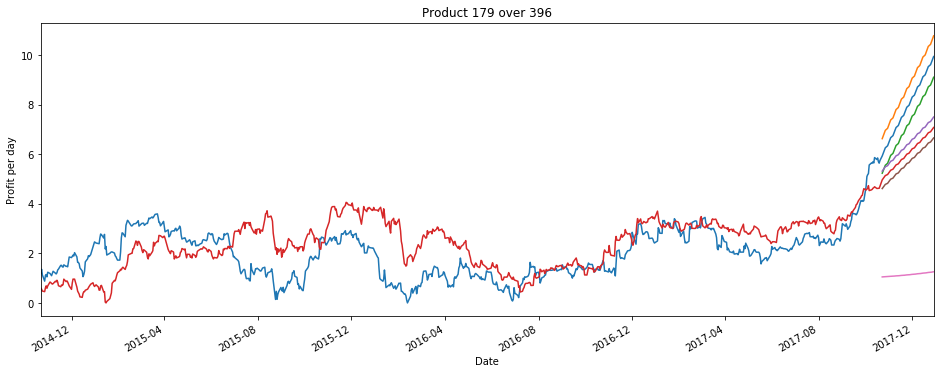

In [2024]:
# prod1 = 0#313
# prod2 = 248#396
prod1 = 179#0#313
prod2 = 396#235
#prod2 = 387
# prod1 = 399
# prod2 = 372


df_forecast_yearend['{}'.format(prod1)].plot(figsize=lrg)
df_forecast_yearend['{}_iv_u'.format(prod1)].plot()
df_forecast_yearend['{}_iv_l'.format(prod1)].plot()

df_forecast_yearend['{}'.format(prod2)].plot()
df_forecast_yearend['{}_iv_u'.format(prod2)].plot()
df_forecast_yearend['{}_iv_l'.format(prod2)].plot()

plt.title('Product {} over {}'.format(prod1,prod2))
plt.ylabel('Profit per day')

spread1 = (df_forecast_yearend['{}_iv_u'.format(prod1)]-df_forecast_yearend['{}_iv_l'.format(prod1)])
spread2 = (df_forecast_yearend['{}_iv_u'.format(prod2)]-df_forecast_yearend['{}_iv_l'.format(prod2)])

((spread1+spread2)/2).plot()
((spread1+spread2)/2).sum()


print('P1 Profit: {:.02f}'.format(prods_forecast[str(prod1)].sum()))
print('P2 Profit: {:.02f}'.format(prods_forecast[str(prod2)].sum()))
print('P1 over P2 profit: {:.02f}'.format(P.iloc[prod1,prod2]))
print('Error +/- {:.02f}'.format(C.iloc[prod1,prod2]/2))


Altogether most profitable 10 products

In [2110]:
most_profitable = list(prods_forecast[only_prods].sum().sort_values(ascending=False).iloc[:10].index)
most_profitable = [int(i) for i in most_profitable]

most_profitable

[0, 313, 179, 335, 310, 31, 305, 113, 367, 396]

Pairing the most_profitable products with a random selection of products from the rest of the products gives a reasonable idea when comparing. I found that comparing the most profitable products against themselves wasn't very informative.

In [2025]:
rand_pairs = []
for mp in most_profitable:
    for i in range(10):
        rand_pairs.append((mp,np.random.randint(0,prods_confid.shape[1])))

In [2013]:
# pairs = []
# for mp in most_profitable:
#     for i in range(428):
#         pairs.append((mp,i))

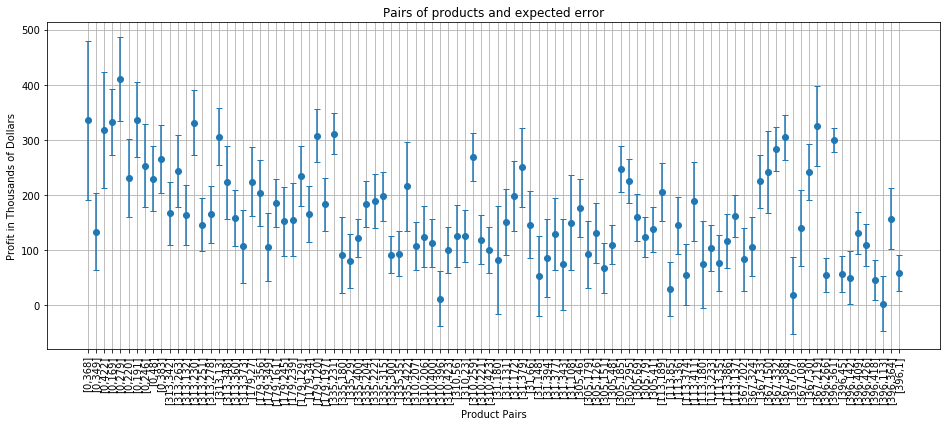

In [2043]:
x = []
y = []
y_err = []
labels = []
for i,j in enumerate(rand_pairs):
#     print(i)
#     print(j)
    labels.append('[{},{}]'.format(j[0],j[1]))
    x.append(i)
    y.append(P.iloc[j[0],j[1]])
    y_err.append(C.iloc[j[0],j[1]]/2)

plt.figure(figsize=lrg)
plt.errorbar(x,y,yerr=y_err,capsize=3,fmt='o')
plt.xticks(x, labels, rotation='vertical')
plt.xlabel('Product Pairs')
plt.ylabel('Profit in Thousands of Dollars')
plt.title('Pairs of products and expected error')
plt.grid(True)

In [1491]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('Date',axis=1)

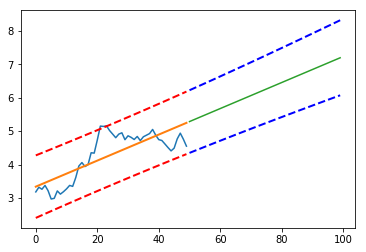

In [1674]:
#prod = '368'
prod = '31'
#prod = '387'

#X = range(df[-trend_dur:].shape[0])
x = np.linspace(0,df[-trend_dur:].shape[0]-1,trend_dur)
X = sm.add_constant(x)
y = df[-trend_dur:][prod]
re = sm.OLS(y, X).fit()


#new_x = np.linspace(trend_dur,forecast_dur,trend_dur)
new_x = np.linspace(trend_dur,trend_dur+forecast_dur-1,trend_dur)
new_x = sm.add_constant(new_x) 
y_predict = re.predict(new_x)
prstd, iv_l, iv_u = wls_prediction_std(re,exog=new_x)
iv_spread = iv_u-iv_l

st, data, ss2 = summary_table(re, alpha=.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
# print(np.max(np.abs(re.fittedvalues - fittedvalues)))
# print(np.max(np.abs(iv_l - predict_ci_low)))
# print(np.max(np.abs(iv_u - predict_ci_upp)))

plt.plot(x, y, '-')
plt.plot(x, fittedvalues, '-', lw=2)
plt.plot(x, predict_ci_low, 'r--', lw=2)
plt.plot(x, predict_ci_upp, 'r--', lw=2)
# plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
# plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)

plt.plot(new_x[:,1],y_predict)
plt.plot(new_x[:,1],iv_l,'b--',lw=2)
plt.plot(new_x[:,1],iv_u,'b--',lw=2)

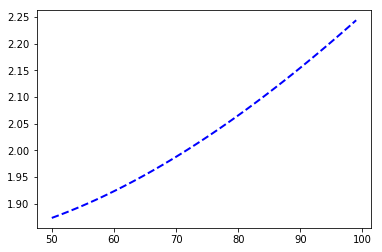

In [1675]:
plt.plot(new_x[:,1],iv_u-iv_l,'b--',lw=2)

4)​ ​Single-day​ ​anomalies.​ ​40 points

The dataset includes some single-day anomalies where profitability jumped up or down unexpectedly
across a number of products. CoolBrand executives think we should investigate them. They may happen
on different products on different days, but CoolBrand is mostly interested in anomalies affecting multiple
high-profit products on the same day. Can you help them identify these types of anomalies in the data?

#### Thoughts

Focus on x top performing products from a specified timeframe, find the difference between dates per product, sum all products diff together, and theshold it/find max to find date. 

Another way of going about this would be to look at the product % increase/decrease as opposed to the actual $ diff. Might be a better idea, I haven't looked at the size of the products sales - only the difference.

The way I'm filtering the top products seems like its biasing the outcome to only recent dates of best products.. another way? larger timeframe?

In [2481]:
df = pd.read_csv('../Downloads/ADM_problem_set_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
#df = df.drop('Date',axis=1)

In [2381]:
top_x = 20
start = '2017' # change to 2017 for only this year
stop = '2017'
top_prods = list(df[start:stop].mean().sort_values(ascending=False).iloc[:top_x].index)
df_best_prods = df[top_prods]

df_top_pos_change = df_best_prods[df_best_prods.diff()>0]

df_top_pos_change.sum(axis=1).sort_values(ascending=False).iloc[:10]

Date
2017-10-02    76.036614
2017-03-01    74.183020
2017-10-20    72.963780
2017-06-19    71.397077
2017-02-21    71.075204
2017-03-15    70.849851
2017-10-13    70.187101
2017-06-09    68.990692
2017-04-24    68.269774
2017-09-25    67.921176
dtype: float64

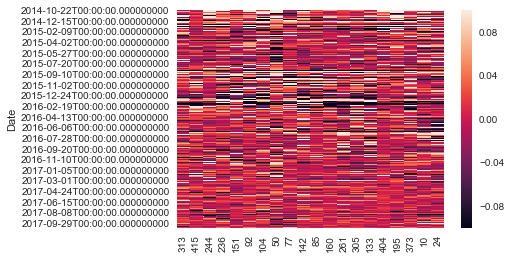

In [2382]:
sns.heatmap(df_best_prods.pct_change()[top_prods])

Average gives a decent idea of the power per product in the top 20, this can be compared witht he average of all products. These dates are clearly clustered in the recent past because I've selected the past month's top performing products and I would imagine product performance is highly time dependent.

In [604]:
df_top_pos_change.mean(axis=1).sort_values(ascending=False).iloc[:10]

Date
2017-10-12    4.732517
2017-10-09    4.641237
2017-10-16    4.426458
2017-10-13    4.386694
2017-09-27    4.377674
2017-10-06    4.372067
2017-10-11    4.365302
2017-07-21    4.357187
2017-10-10    4.292414
2017-10-20    4.291987
dtype: float64

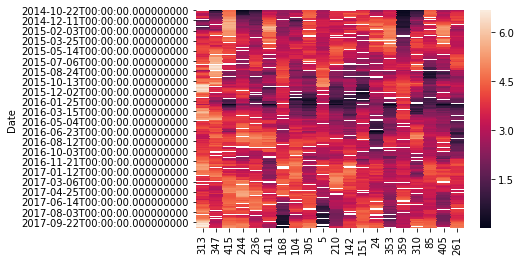

In [326]:
sns.heatmap(df_top_pos_change)

When finding highest increase across all products the resulting dates are different, so there should be careful consideration when deciding which products to include and what that means when evaluating

In [335]:
df_pos_change = df[df.diff()>0]

In [605]:
df_pos_change.mean(axis=1).sort_values(ascending=False).iloc[:10]

Date
2017-10-06    3.539917
2017-10-12    3.436988
2017-10-20    3.324994
2017-10-09    3.284429
2017-10-11    3.230372
2017-10-02    3.203799
2017-10-19    3.190033
2017-10-05    3.179663
2017-10-13    3.168683
2017-10-16    3.146270
dtype: float64

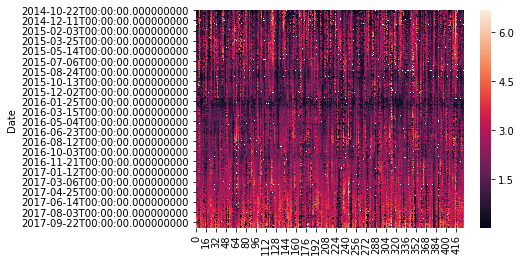

In [328]:
sns.heatmap(df_pos_change)

#### Additional Work

I wanted to look at the percent change of the products in addition to the original work of looking at the gross increase profit over all the products. This results in a selection of different best/worst dates over the same products.

It turns out the top percent increase number is an anomoly due to a price rising from near zero and is throwing off the calculation. Therefore I changed the method of finding the values from __mean__ to __median__ which produces a much more robust approximation to the highest increase day.

In [2298]:
df_best_prods.diff().replace(np.inf,np.nan).dropna().mean(axis=1).sort_values(ascending=False).head()

Date
2015-10-05    0.275632
2015-08-27    0.251345
2016-02-17    0.214496
2017-03-01    0.213875
2016-01-22    0.208771
dtype: float64

In [2337]:
df_best_prods_pct = df_best_prods.pct_change().replace(np.inf,np.nan).dropna()#.mean(axis=1).sort_values(ascending=False).head()
df_best_prods.pct_change().replace(np.inf,np.nan).dropna().median(axis=1).sort_values(ascending=False).head()


Date
2016-02-17    0.207120
2016-02-16    0.177071
2015-10-05    0.147578
2016-02-04    0.118555
2016-02-22    0.094674
dtype: float64

In [2340]:
def top_pct_dates(df_best_prods_pct,position=0):
    top_pct_date = df_best_prods_pct.median(axis=1).sort_values(ascending=False).index[position]
    top_pct = df_best_prods_pct.median(axis=1).sort_values(ascending=False)[position]
    return top_pct_date, top_pct

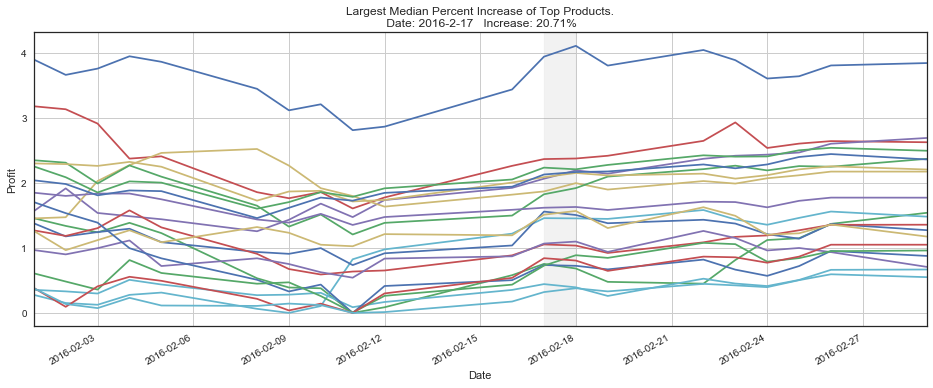

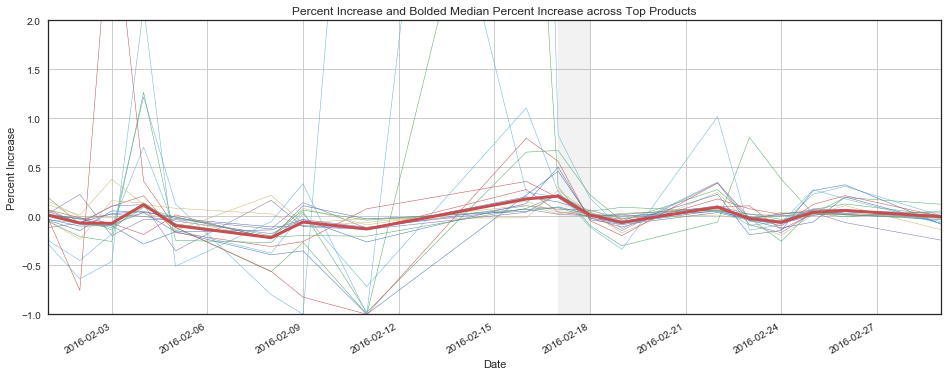

In [2345]:
top_pct_date, top_pct = top_pct_dates(df_best_prods_pct,0)
top_pct_day = '{}-{}-{}'.format(top_pct_date.year,top_pct_date.month,top_pct_date.day)
top_pct_viz = '{}-{}'.format(top_pct_date.year,top_pct_date.month)
df_best_prods[top_prods][top_pct_viz].plot(figsize=lrg,legend=False)
plt.title('Largest Median Percent Increase of Top Products.\n Date: {}   Increase: {:.02f}%'.format(top_pct_day,100*top_pct))
plt.axvspan(top_pct_date,'{}-{}-{}'.format(top_pct_date.year,top_pct_date.month,top_pct_date.day+1),alpha=.1,color='gray')
plt.grid(True)
plt.ylabel('Profit')

df_best_prods_pct[top_prods][top_pct_viz].plot(figsize=lrg,legend=False,lw=.5)
df_best_prods_pct[top_prods][top_pct_viz].median(axis=1).plot(figsize=lrg,legend=False,lw=3)
plt.title('Percent Increase and Bolded Median Percent Increase across Top Products')
plt.axvspan(top_pct_date,'{}-{}-{}'.format(top_pct_date.year,top_pct_date.month,top_pct_date.day+1),alpha=.1,color='gray')
plt.ylabel('Percent Increase')
#plt.yscale('log')
plt.ylim(-1,2)
plt.grid(True)

The distribution below shows how the mean is effected by outliers much more than the median which I think is a better metric for highest perc change day.

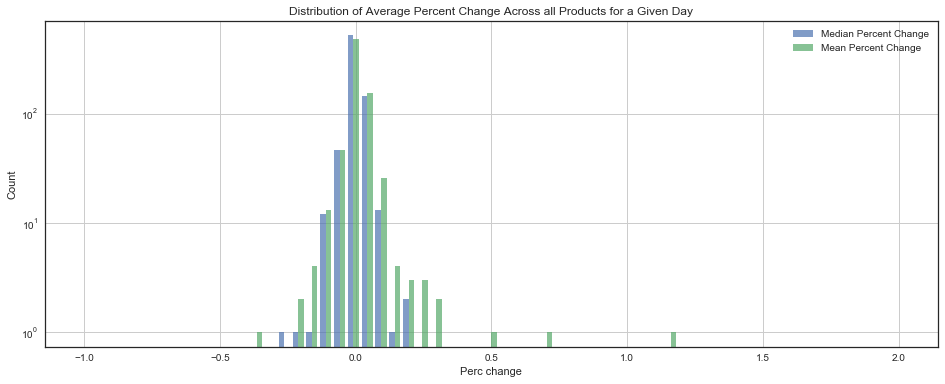

In [2371]:
# df_best_prods.pct_change().replace(np.inf,np.nan).dropna().median(axis=1).hist(bins=30,figsize=lrg)
# df_best_prods.pct_change().replace(np.inf,np.nan).dropna().mean(axis=1).hist(bins=30)

x = df_best_prods.pct_change().replace(np.inf,np.nan).dropna().median(axis=1)
y = df_best_prods.pct_change().replace(np.inf,np.nan).dropna().mean(axis=1)
data = np.vstack([x, y]).T
bins = np.linspace(-1, 2, 60)

plt.figure(figsize=lrg)
plt.hist(data, bins, alpha=0.7, label=['Median Percent Change', 'Mean Percent Change'])
plt.legend(loc='upper right')

plt.xlabel('Perc change')
plt.ylabel('Count')
plt.title('Distribution of Average Percent Change Across all Products for a Given Day')
plt.yscale('log')
plt.grid(True)

#### Additional Thoughts

At this point it seems like the figuring out which products I want to display and how to best display information based on which are related to each other would be worthwhile. What I would like to do is to cluster them and find a number of product categories that tend to rise and fall at the same time. Similar to what I did in #4 and #2 except I want to cluster across all time as opposed to the specific events I was analyzing before. I would like to use all these features in my evaluation, though I'll start out with the raw data first

In [2510]:
from sklearn.cluster import k_means

In [2511]:
df = df.replace(np.nan,0)
df_pct = df_pct.replace(np.nan,0)

k = k_means(df.T,n_clusters=9)

In [2508]:
k[1]

array([2, 7, 7, 3, 3, 4, 1, 8, 3, 3, 0, 3, 8, 6, 3, 7, 6, 6, 7, 3, 7, 7, 7,
       7, 5, 2, 8, 3, 7, 2, 6, 2, 3, 1, 8, 2, 3, 3, 7, 1, 7, 8, 3, 1, 1, 8,
       7, 7, 3, 4, 0, 7, 1, 8, 8, 3, 8, 7, 3, 6, 6, 6, 1, 7, 3, 4, 3, 5, 5,
       1, 3, 7, 4, 3, 2, 8, 2, 5, 2, 8, 6, 2, 6, 8, 3, 5, 6, 3, 0, 5, 7, 3,
       5, 2, 8, 7, 8, 7, 7, 0, 7, 3, 8, 7, 5, 1, 7, 7, 7, 3, 3, 5, 6, 7, 7,
       8, 4, 3, 2, 0, 1, 5, 1, 1, 1, 7, 5, 5, 8, 3, 3, 3, 8, 2, 5, 8, 7, 7,
       8, 5, 5, 6, 5, 1, 7, 7, 6, 8, 7, 7, 3, 5, 8, 8, 6, 7, 1, 3, 5, 4, 5,
       3, 8, 7, 8, 1, 1, 3, 4, 6, 3, 7, 6, 1, 5, 3, 3, 4, 7, 2, 5, 6, 7, 8,
       5, 6, 1, 8, 7, 2, 1, 1, 0, 3, 2, 0, 7, 3, 7, 1, 5, 8, 8, 3, 3, 3, 2,
       8, 5, 8, 5, 5, 7, 7, 3, 1, 5, 8, 5, 7, 3, 3, 0, 1, 7, 8, 7, 4, 6, 3,
       6, 7, 4, 3, 8, 3, 0, 2, 2, 0, 2, 7, 3, 8, 0, 2, 8, 4, 6, 6, 2, 8, 3,
       7, 7, 8, 4, 7, 3, 6, 0, 2, 3, 3, 6, 3, 2, 3, 7, 0, 5, 0, 2, 6, 3, 6,
       1, 2, 8, 7, 4, 7, 1, 1, 3, 4, 7, 6, 8, 7, 2, 6, 8, 3, 4, 6, 5, 5, 2,
       5, 8,

Average Profit by cluster

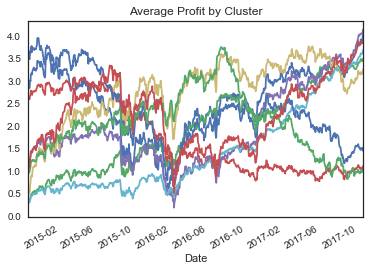

In [2512]:

for groupid in range(9):
    grp = [str(col) for col in np.where(k[1] == groupid)[0]]
    df[grp].mean(axis=1).plot()
plt.title('Average Profit by Cluster')

#### Additional Thoughts

1. 
